In [1]:
import pandas as pd
import numpy as np
games = pd.read_csv('Games_Final.csv') 


In [2]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14673 entries, 0 to 14672
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   evals               14673 non-null  object 
 1   cheating_pos        14673 non-null  object 
 2   cheating            14673 non-null  bool   
 3   cheating_magnitude  14673 non-null  float64
dtypes: bool(1), float64(1), object(2)
memory usage: 358.4+ KB


In [3]:
import ast
games = games[(games['cheating_magnitude'] > 0.2) | (games['cheating_magnitude'] == 0)].reset_index(drop=True)
evals = games['evals'].to_list()
cheating_pos = games['cheating_pos'].to_list()
cheating_magnitudes = games['cheating_magnitude'].to_list()
evals = [ast.literal_eval(evals[i]) for i in range(len(evals))]
cheating_pos = [ast.literal_eval(cheating_pos[i]) for i in range(len(cheating_pos))]
cheating = games['cheating'].to_list()

In [4]:
len(cheating_pos), len(evals), len(cheating_magnitudes), len(cheating), len(games['cheating_magnitude'])

(13378, 13378, 13378, 13378, 13378)

In [5]:
import numpy as np

import matplotlib.pyplot as plt

def plot_evals_with_anomalies(evals, cheating_pos):
    """
    Plotea los valores de evals y resalta las anomalías indicadas por cheating.

    Args:
        evals (list or np.ndarray): Valores numéricos a graficar.
        cheating (list or np.ndarray): Vector binario que indica anomalías (1 para anomalía, 0 para normal).
    """
    evals = np.array(evals)
    cheating_pos = np.array(cheating_pos)

    plt.figure(figsize=(12, 6))
    plt.plot(evals, label='Evals', color='blue')

    # Resaltar las anomalías
    for i in range(len(cheating_pos)):
        if cheating_pos[i] == 1:
            plt.axvspan(i - 0.5, i + 0.5, color='red', alpha=0.3)

    plt.xlabel('Index')
    plt.ylabel('Evals')
    plt.title('Evals with Anomalies Highlighted')
    plt.legend()
    plt.grid(True)
    plt.show()

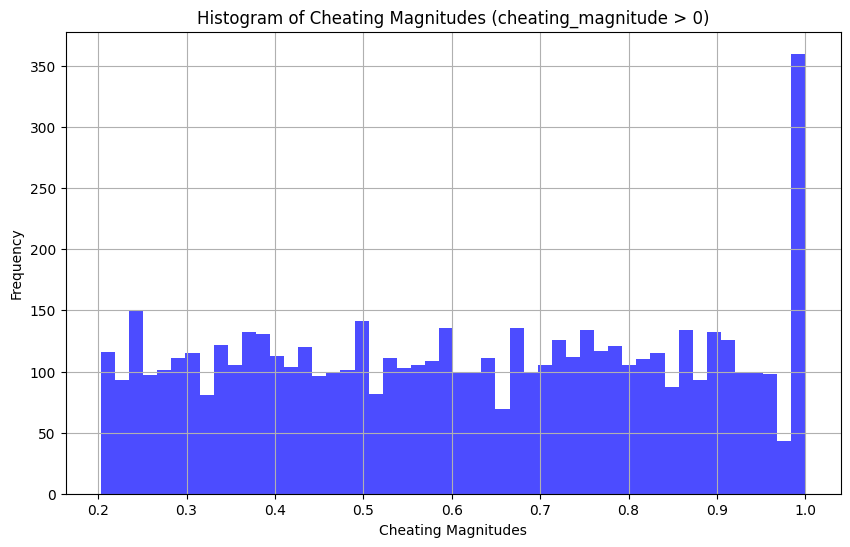

In [6]:
plt.figure(figsize=(10, 6))
plt.hist([m for m in cheating_magnitudes if m > 0], bins=50, color='blue', alpha=0.7)
plt.xlabel('Cheating Magnitudes')
plt.ylabel('Frequency')
plt.title('Histogram of Cheating Magnitudes (cheating_magnitude > 0)')
plt.grid(True)
plt.show()

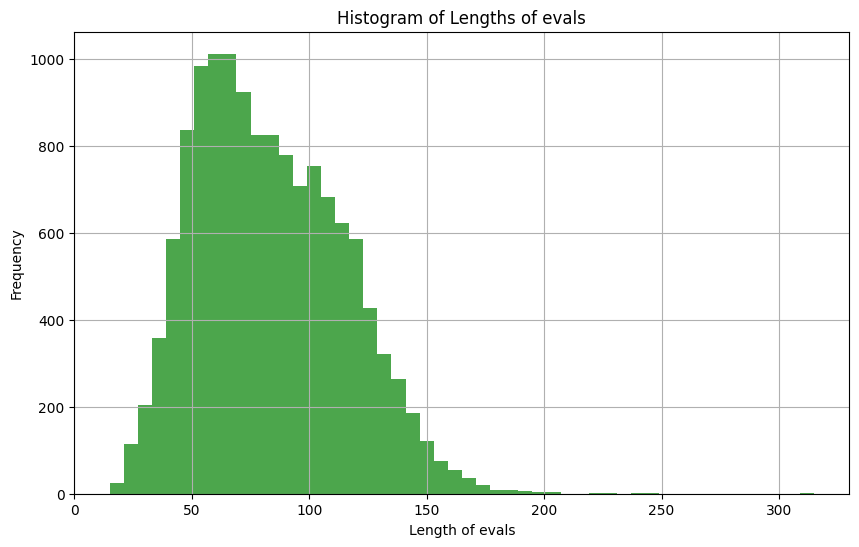

In [7]:
eval_lengths = [len(e) for e in evals]

plt.figure(figsize=(10, 6))
plt.hist(eval_lengths, bins=50, color='green', alpha=0.7)
plt.xlabel('Length of evals')
plt.ylabel('Frequency')
plt.title('Histogram of Lengths of evals')
plt.grid(True)
plt.show()

i:  7680
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1]
57
59
cheating_magnitude:  0.9


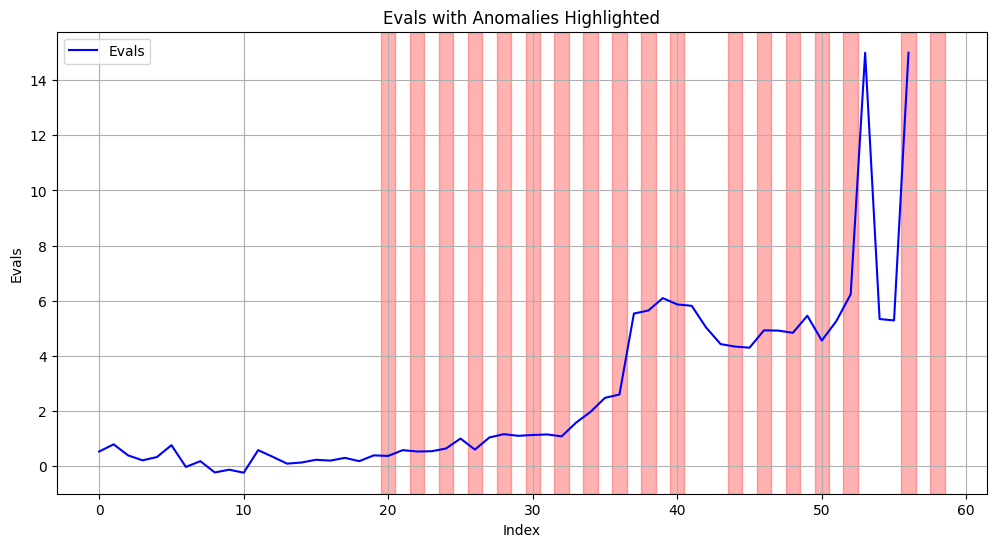

In [8]:
indices = games[games['cheating_magnitude'] > 0].index.tolist()
i = indices[7]
print("i: ", i)
print(cheating_pos[i])
print(len(evals[i]))
print(len(cheating_pos[i]))
print("cheating_magnitude: ", cheating_magnitudes[i])
plot_evals_with_anomalies(evals[i], cheating_pos[i])

In [72]:
from collections import Counter

cheating_counts = Counter(cheating)
print(cheating_counts)

Counter({False: 7673, True: 5705})


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def pad_with_last_value(sequences, max_len):
    padded = []
    for seq in sequences:
        seq = list(seq)
        if len(seq) >= max_len:
            padded.append(seq[:max_len])
        else:
            last_val = seq[-1] if seq else 0.0  # fallback to 0.0 if empty
            padded_seq = seq + [last_val] * (max_len - len(seq))
            padded.append(padded_seq)
    return np.array(padded, dtype=np.float32)


max_len = 150
#X = pad_sequences(evals, maxlen=max_len, padding='post', truncating='post',  dtype='float32')
X = pad_with_last_value(evals, max_len)
y = np.array(cheating)  
np.save('X.npy', X)
np.save('y.npy', y)


# Dividir en Train (60%), Val (20%) y Test (20%)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full
)



# Calculate class weights based on the training set
# class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Create a dictionary for the class weights
#class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Define a simple dense model
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),  # Assuming X_train has shape (n_samples, n_features)
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification (cheating vs not)
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using the training set with class weights
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Evaluate the model on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob >= 0.90).astype(int)  # Apply threshold of 0.5 to get the final prediction

# Print the classification report for test set
print(classification_report(y_test, y_pred))


Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6736 - loss: 0.9809 - val_accuracy: 0.7855 - val_loss: 0.4820
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7881 - loss: 0.4746 - val_accuracy: 0.7982 - val_loss: 0.5211
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8092 - loss: 0.4434 - val_accuracy: 0.7840 - val_loss: 0.4753
Epoch 4/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7984 - loss: 0.4306 - val_accuracy: 0.7889 - val_loss: 0.4560
Epoch 5/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8203 - loss: 0.4135 - val_accuracy: 0.7967 - val_loss: 0.4343
Epoch 6/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8039 - loss: 0.4188 - val_accuracy: 0.8359 - val_loss: 0.3878
Epoch 7/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8199 - loss: 0.3993 - val_accuracy: 0.8158 - val_loss: 0.4083
Epoch 8/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8240 - loss: 0.3962 - val_accuracy: 0.

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step


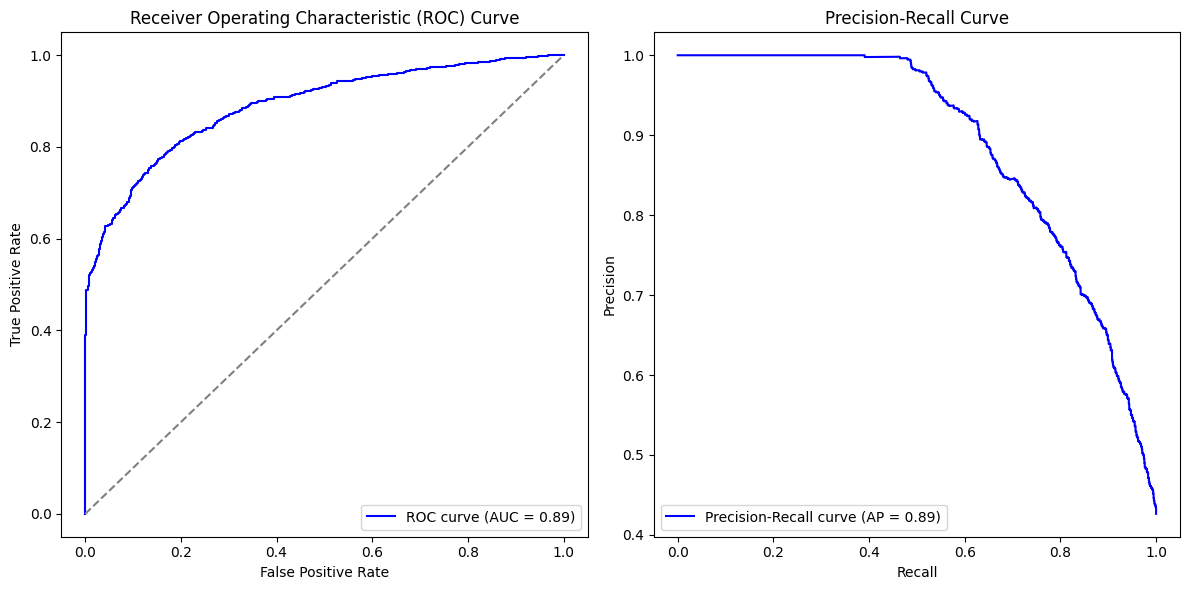

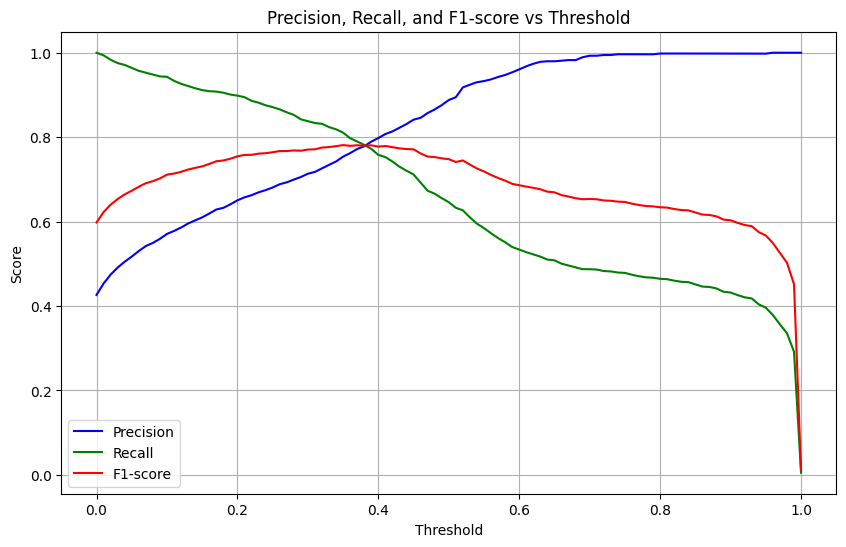

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Obtener las probabilidades de predicción del modelo en el conjunto de prueba
y_pred_prob = model.predict(X_test)

# Calcular la curva ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Calcular la curva de Precisión-Recall
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

# Graficar la Curva ROC
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Graficar la Curva de Precisión-Recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


from sklearn.metrics import precision_score, recall_score, f1_score

# Umbrales a evaluar
thresholds_roc = np.linspace(0, 1, 101)

# Listas para almacenar los resultados
precisions = []
recalls = []
f1_scores = []

# Iterar sobre los diferentes umbrales
for threshold in thresholds_roc:
    y_pred = (y_pred_prob >= threshold).astype(int)
    
    # Calcular precision, recall y f1-score usando sklearn
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Guardar los valores
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Graficar las métricas en función del umbral
plt.figure(figsize=(10, 6))
plt.plot(thresholds_roc, precisions, color='blue', label='Precision')
plt.plot(thresholds_roc, recalls, color='green', label='Recall')
plt.plot(thresholds_roc, f1_scores, color='red', label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [67]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Supón que ya tienes dos listas:
#   evals: lista de listas de floats con las evaluaciones por movimiento
#   cheating: lista de ceros y unos indicadoras de si blancas hicieron trampa

# Parámetros
max_len = 150  # longitud máxima de secuencia
batch_size = 64
epochs = 10

# Función para preparar los datos con padding/truncado
def prepare_data(evals, cheating, max_len):
    # Rellenar/truncar secuencias
    X = pad_sequences(
        evals,
        maxlen=max_len,
        dtype='float32',
        padding='post',      # añade ceros al final si es más corta
        truncating='post',    # trunca al final si es más larga
        value=42.0             # valor para padding
    )
    # Añadir dimensión de canal para LSTM
    X = np.expand_dims(X, axis=2)  # shape: (n_samples, max_len, 1)
    y = np.array(cheating, dtype='float32')
    return X, y

# Convertir datos
X, y = prepare_data(evals, cheating, max_len)

# Dividir en Train (60%), Val (20%) y Test (20%)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full
)
# Ahora:
#  - X_train, y_train: 60% de los datos
#  - X_val,   y_val:   20% de los datos
#  - X_test,  y_test:  20% de los datos

# Definir el modelo
model = Sequential([
    Masking(mask_value=42.0, input_shape=(max_len, 1)),
    LSTM(64, return_sequences=False),
    Dense(1, activation='sigmoid')
])

# Compilar
model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Ver resumen
model.summary()

# Entrenar con conjunto de validación
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val)
)

# Evaluar en Test
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Guardar modelo si lo deseas
# model.save('lstm_cheating_detector.h5')


c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ (None, 150, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.6780 - loss: 0.6100 - val_accuracy: 0.6835 - val_loss: 0.5819
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.7079 - loss: 0.5685 - val_accuracy: 0.7123 - val_loss: 0.5694
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.7128 - loss: 0.5707 - val_accuracy: 0.6794 - val_loss: 0.6183
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.7081 - loss: 0.5741 - val_accuracy: 0.7201 - val_loss: 0.5593
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.7420 - loss: 0.5427 - val_accuracy: 0.7347 - val_loss: 0.5368
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.7419 - loss: 0.5280 - val_accuracy: 0.7657 - val_loss: 0.5013
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.7643 - loss: 0.4807 - val_accuracy: 0.7485 - val_loss: 0.5078
Epoch 8/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.7489 - loss: 0.5050 - val_ac

84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


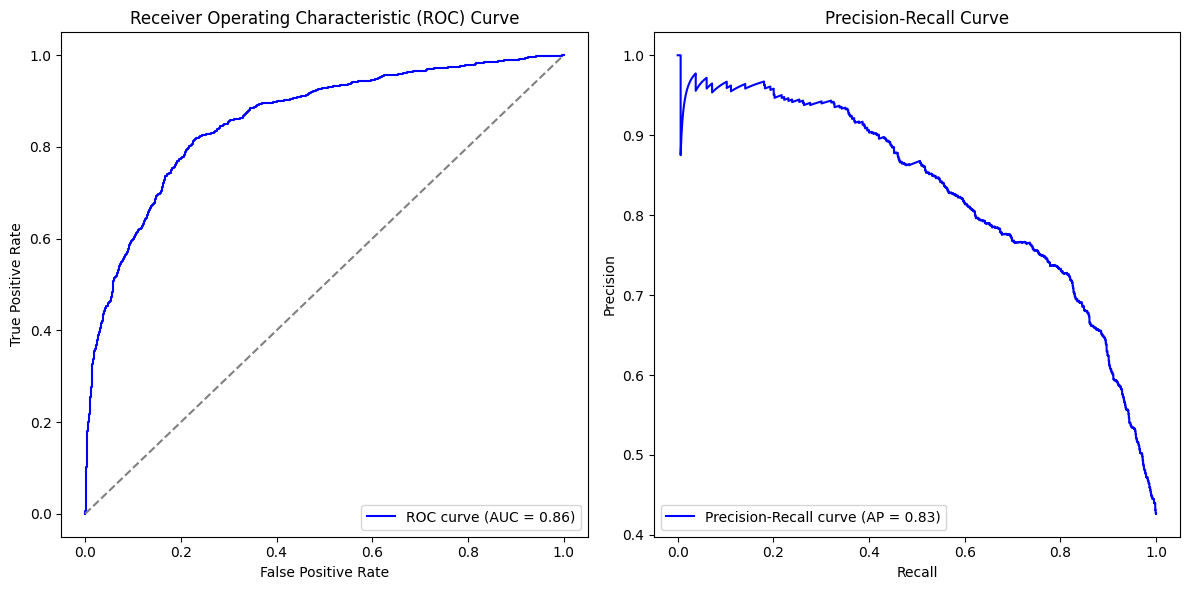

c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

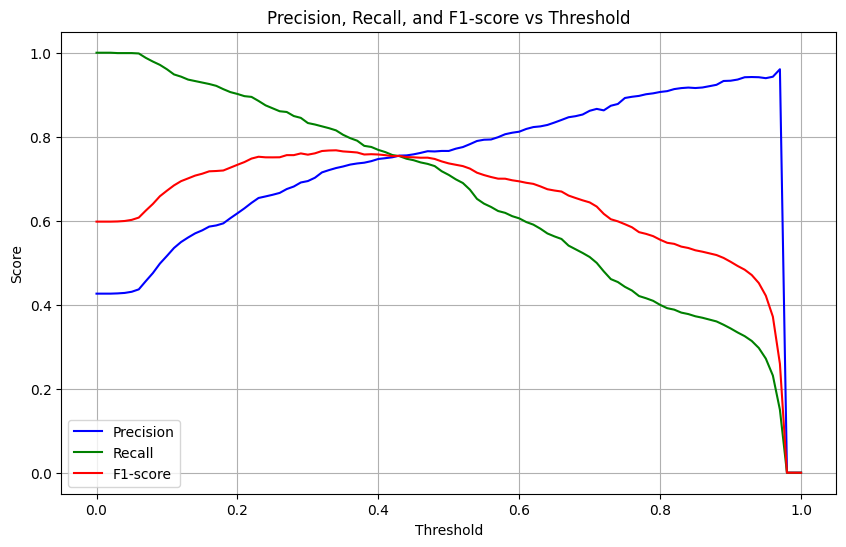

In [68]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Obtener las probabilidades de predicción del modelo en el conjunto de prueba
y_pred_prob = model.predict(X_test)

# Calcular la curva ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Calcular la curva de Precisión-Recall
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

# Graficar la Curva ROC
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Graficar la Curva de Precisión-Recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


from sklearn.metrics import precision_score, recall_score, f1_score

# Umbrales a evaluar
thresholds_roc = np.linspace(0, 1, 101)

# Listas para almacenar los resultados
precisions = []
recalls = []
f1_scores = []

# Iterar sobre los diferentes umbrales
for threshold in thresholds_roc:
    y_pred = (y_pred_prob >= threshold).astype(int)
    
    # Calcular precision, recall y f1-score usando sklearn
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Guardar los valores
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Graficar las métricas en función del umbral
plt.figure(figsize=(10, 6))
plt.plot(thresholds_roc, precisions, color='blue', label='Precision')
plt.plot(thresholds_roc, recalls, color='green', label='Recall')
plt.plot(thresholds_roc, f1_scores, color='red', label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [63]:
import tensorflow as tf
import numpy as np

# Define the inverse model
inverse_model = tf.keras.Sequential([
    layers.Input(shape=(max_len,)),  # Input shape matches the input to the classification model
    layers.Dense(64, activation='relu'),
    layers.Dense(max_len, activation='relu')  # Output shape matches the input shape
])

# Compile the inverse model
inverse_model.compile(optimizer='adam', loss='mse')

# Define a custom loss function to maximize the cheating probability
def custom_loss(y_true, y_pred):
    cheating_prob = model(y_pred)  # Get the cheating probability from the classification model
    return -tf.reduce_mean(cheating_prob)  # Negate the probability to maximize it

# Generate random initial input for the inverse model
initial_input = np.random.uniform(-15, 15, size=(1, max_len)).astype('float32')

# Train the inverse model
inverse_model.fit(
    x=initial_input,
    y=np.zeros_like(initial_input),  # Dummy target, as the loss is custom
    epochs=20,
    batch_size=1,
    verbose=1
)

# Get the "most cheating" game
most_cheating_game = inverse_model.predict(initial_input)
print("Most cheating game:", most_cheating_game)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step - loss: 21.6913
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 17.3486
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 13.8588
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 11.0323
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 8.8072
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 7.0284
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 5.6106
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.5069
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 3.6573
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 2.9806
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.4212
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.9615
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.5938
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 1.3040
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 1.0777
Epoch 16/20
1/1 ━━━━━━━━━━━━━